In [38]:
%matplotlib inline
from torch.utils.data import Dataset
import numpy as np
import os, glob
from pathlib import Path
import json
import random
import torch
from PIL import Image
from torchvision.transforms import Compose, ToTensor, Resize
from math import sqrt
import torchvision
import matplotlib 
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from IPython import display
from time import sleep


ModuleNotFoundError: No module named 'tkinter'

In [29]:
seed = 420
class RealEstateLoader(Dataset):
	def __init__(self, configs):
		self.configs = configs
		self.dir = self.configs['dataset_root'] #/home5/anwar/data/realestate10k/
		self.mode = configs['mode']
		self.indices = np.loadtxt(os.path.join(self.dir, 'valid_folders_%s2.txt' %self.mode) , dtype=np.str)
		self.indices = self.indices.reshape((-1,))
		#print('Paths', glob.glob(os.path.join(self.dir, 'extracted', self.mode, self.indices[0], '*.jpg')))
		#print('Indices', len(self.indices))
		self.indices = self.indices[:5]
		self.frames = [glob.glob(os.path.join(self.dir, 'extracted', self.mode, id + '.txt', '*.jpg')) for id in self.indices]
		#self.text = [glob.glob(os.path.join(self.dir, 'text_files', self.mode, id + '.txt')) for id in self.indices]
		#print('ff', len(self.frames))
		self.frames = np.array([np.array(y) for x in self.frames for y in x])
		#self.text = np.array([np.array(y) for x in self.text for y in x])
		#print('ff', len(self.frames))
		self.text_dir = os.path.join(self.dir, 'text_files', self.mode)
		#self.frames = self.frames.flatten()
		#self.text = self.text.flatten()
		#print('ss', len(self.text))
		#print('Frames', self.frames[:2])
		# self.frames = [os.path.join(self.dir, 'extracted', self.mode, clip, frame) for clip in self.indices]
		# self.text = [os.path.join(self.dir, 'text_files', self.mode, clip, frame) for clip in self.indices]

		self.min_angle = 5
		self.max_angle = 30
		self.min_trans = 0.3
		self.rng = np.random.RandomState(seed)

		self.transform = Compose([
								Resize((self.configs['width'], self.configs['height'])),
								ToTensor()
								])

		#print(len(self.frames))

	def __getitem__(self, index):
		src_frame = self.frames[index]
		#print('src_frame', src_frame)
		_, target_frame, k_matrix, r_rel, t_rel = self._get_target_frame_and_poses(src_frame)

		src_img = self.transform(Image.open(src_frame))
		target_img = self.transform(Image.open(target_frame))

		data_dict = {}
		data_dict['input_img'] = src_img
		data_dict['target_img'] = target_img
		data_dict['k_mats'] = k_matrix
		data_dict['r_mats'] = r_rel
		data_dict['t_vecs'] = t_rel

		#print('k', k_matrix)
		#print('r', r_rel)
		#print('r det', np.linalg.det(r_rel.numpy()))
		#print('t', t_rel)

		return data_dict
    
	def __len__(self):
		return len(self.indices)
    

	def _get_target_frame_and_poses(self, src_frame):
		seq = Path(src_frame).parent
		src_idx = Path(src_frame).stem
		text_path = os.path.join(self.text_dir, seq.stem + '.txt')
		#print('PRINTING')
		#print(src_idx)
		#print(seq.stem)
		#print('text file', text_path)

		#intrinsics_path = os.path.join(seq, 'intrinsics.txt')
		#extrinsics_path = os.path.join(seq, 'extrinsics.txt')

		#with open(intrinsics_path, 'r') as data:
		#	intrinsics = json.load(data)
		#with open(extrinsics_path, 'r') as data:
		#	extrinsics = json.load(data)

		text_file = np.loadtxt(text_path, comments='https')
		#print(text_file.shape)
		intrinsics = text_file[int(src_idx), 1:7]
		extrinsics = text_file[int(src_idx), 7:]
		#print(intrinsics.shape, extrinsics.shape)
		k_matrix = self._get_intrinsics(intrinsics)
		pose_src = self._get_extrinsics(extrinsics)

		seq_len = len(text_file)
		#print('seq_len', text_file.shape)


		# Chose 15 images within 30 frames of the iniital one
		target_candidates = self.rng.randint(self.configs['max_baseline'] * 6, size=(self.configs['max_baseline'] * 3)) - self.configs['max_baseline']//2 + int(src_idx)
		target_candidates = np.minimum(np.maximum(target_candidates, 0), seq_len - 1)

		#max_offset = min(self.configs['max_baseline'], len(intrinsics))
		#assert max_offset>0, 'offset should be atleast 1'

		#offset = 1
		#if max_offset > 1:
		#	offset = self.rng.randint(1, max_offset-1)
		#if self.rng.random() > 0.5:
		#	offset = -offset

		#target_idx = int(src_idx) + offset
		#target_idx = max(0, target_idx)
		#target_idx = min(target_idx, seq_len - 1)
		angles = []
		translations = []

		for cand in target_candidates:
			pose_cand = self._get_extrinsics(text_file[cand][7:])
			dang, dtrans = self._get_deltas(pose_src, pose_cand)
			angles += [dang]
			translations += [dtrans]

		angles = np.array(angles)
		translations = np.array(translations)
		print(translations)
		mask = target_candidates[(angles < self.max_angle) & (translations > self.min_trans)]
		print(mask)
		if(mask.shape[0] > 2):
			target_idx = mask[self.rng.randint(mask.shape[0])]
		else:
			target_idx = target_candidates[self.rng.randint(target_candidates.shape[0])]

		target_frame = os.path.join(seq, str(target_idx).zfill(4) + '.jpg')

		extrinsics_t = text_file[int(target_idx)][7:]
		pose_target = self._get_extrinsics(extrinsics_t)

		r_rel, t_rel = self._get_relative_pose(pose_src, pose_target)

		return src_frame, target_frame, k_matrix, r_rel, t_rel
    

	def _get_relative_pose(self, pose_src, pose_target):
		r_src, t_src = pose_src[:3, :3], pose_src[:3, 3]
		r_target, t_target = pose_target[:3, :3], pose_target[:3, 3]
		r_rel = torch.mm(r_target.transpose(1, 0), r_src)
		t_rel = torch.mm(r_target.transpose(1,0), (t_src - t_target).view(3, 1))

		return r_rel, t_rel

	def _get_intrinsics(self, intrinsics):
		w, h = self.configs['width'], self.configs['height']
		intrinsics = np.array(intrinsics, dtype=np.float32)
		#print('intrinsics', intrinsics)
		intrinsics = np.array([[intrinsics[0] * w, 0, intrinsics[2] * w],
					[0, intrinsics[1] * h, intrinsics[3] * h],
					[0, 0, 1]],
					dtype=np.float32)
		#print('intrinsics', intrinsics)
		return torch.Tensor(intrinsics)

	def _get_extrinsics(self, extrinsics):
		#print(extrinsics)
		extrinsics = np.array(extrinsics, dtype=np.float32).reshape((3,4))
		return torch.Tensor(extrinsics)

	def _get_deltas(self, mat1, mat2):
		mat1 = np.vstack([mat1, np.array([0,0,0,1])])
		mat2 = np.vstack([mat2, np.array([0,0,0,1])])

		dmat = np.matmul(np.linalg.inv(mat1), mat2)
		dtrans = dmat[:3, 3]**2
		dtrans = sqrt(dtrans.sum())

		orgVec = np.array([[0],[0],[1]])
		rotVec = np.matmul(dmat[:3, :3], orgVec)
		arcos = (rotVec * orgVec).sum() / sqrt((rotVec**2).sum())
		dangle = np.arccos(arcos) * 180.0/np.pi

		return dangle, dtrans



In [37]:
if __name__ == '__main__':
	configs = {}
	configs['dataset_root'] = '/home5/anwar/data/realestate10k/'
	configs['mode'] = 'train'
	configs['max_baseline'] = 5
	configs['height'] = 384
	configs['width'] = 256

	dataset = RealEstateLoader(configs)
	print(len(dataset))
	data = dataset.__getitem__(1)
	print(data['input_img'].shape)
	c, h, w = data['input_img'].shape
    
	fig = plt.figure()
	ax = fig.gca()
	fig.show()
	arr = [data['input_img'], data['target_img']]
	for ii in range(10):
		image = arr[ii % 2]
		plt.imshow(image.permute([1,2,0]), interpolation = 'None')
		ax.set_title(ii)
		fig.canvas.draw()
		sleep(0.2)
# 	torchvision.utils.save_image(data['input_img'], 'input_sample.png')
# 	torchvision.utils.save_image(data['target_img'], 'target_sample.png')



5
[0.18547912 0.07103186 0.04781755 0.21470058 0.14320593 0.314265
 0.33106528 0.09428733 0.07103186 0.27897857 0.14320593 0.04781755
 0.23076512 0.01245653 0.29622986]
[175 176]
torch.Size([3, 256, 384])


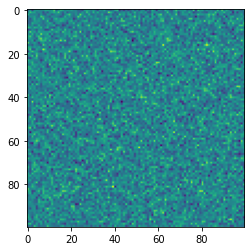

In [20]:
%matplotlib inline


from matplotlib import pyplot as plt
import cv2
import numpy as np
from time import sleep


fig = plt.figure()
fig.show()

for i in range(5):
    img = np.random.randn(100,100)
    # img = cv2.imread('/Users/mustafa/test.jpg')
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(img, animated=True)
#     plt.show()
    fig.canvas.draw()
    
    sleep(0.1)